<a href="https://colab.research.google.com/github/Rishika70/Topic-Modelling-on-Neurology-with-LLM/blob/main/Topic_Modelling_on_Neurology_with_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

### **This project aims to develop a system for analyzing and querying a collection of neurological research documents using topic modeling and large language models (LLMs).  The system will categorize documents based on keywords related to diseases, treatments, types of neurological conditions, and other relevant topics.  A key feature will be a question-answering capability that leverages both the document categories and semantic similarity to provide relevant excerpts from documents in response to user queries.  The system's performance will be evaluated using precision, recall, and F1-score metrics to assess the accuracy of its multi-label document classification.  Ultimately, the goal is to create a tool that efficiently facilitates research by enabling quick analysis and retrieval of information from a large corpus of neurological research papers.**

#Import Libraries and Load SciBERT Models

In [1]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 35.6 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import re
import numpy as np
import torch
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import fitz  # PyMuPDF for PDF text extraction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

#Load the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path where PDFs are extracted
extracted_folder_path = '/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/ScienceDirect_articles_07Nov2024_17-51-14.882.zip (Unzipped Files)'

# List all PDFs in the folder
pdf_files = [os.path.join(extracted_folder_path, f) for f in os.listdir(extracted_folder_path) if f.endswith('.pdf')]
print(f"Found {len(pdf_files)} PDFs.")

Found 18 PDFs.


In [6]:
# Initialize SciBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


#Text Pre-Processing

##Remove Punctuations,Tags, URLS and whitespaces

In [7]:
import re

def clean_text(text):
  # Remove punctuation
  text = re.sub(r'[^\w\s]', '', text)
  # Remove tags
  text = re.sub(r'<.*?>', '', text)
  # Remove URLs
  text = re.sub(r'http\S+', '', text)
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  return text

##Tokenization

In [8]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def tokenize_text(text):
  """Tokenizes the input text using NLTK's word tokenizer.

  Args:
    text: The text to be tokenized.

  Returns:
    A list of tokens.
  """
  tokens = word_tokenize(text)
  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Remove stop words

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
  """Removes stop words from a list of tokens.

  Args:
    tokens: A list of tokens.

  Returns:
    A list of tokens without stop words.
  """
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Convert to lowercase

In [10]:
def lowercase(text):
  """Converts text to lowercase.

  Args:
    text: The text to be converted.

  Returns:
    The lowercase version of the text.
  """
  return text.lower()

##Stemming and Lemmatization

In [11]:
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

def stem_tokens(tokens):
    """Stems a list of tokens using Porter Stemmer.

    Args:
        tokens: A list of tokens.

    Returns:
        A list of stemmed tokens.
    """
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    print(stemmed_tokens)  # Print the stemmed tokens for debugging
    return stemmed_tokens


In [12]:
 ##Lemmatization
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
  """Lemmatizes a list of tokens using WordNet Lemmatizer.

  Args:
    tokens: A list of tokens.

  Returns:
    A list of lemmatized tokens.
  """
  print([lemmatizer.lemmatize(token) for token in tokens])
  return [lemmatizer.lemmatize(token) for token in tokens]


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
# Extract text from PDF
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

In [14]:
# Generate embeddings using SciBERT
def get_embeddings(texts):
    """Generate embeddings using SciBERT."""
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = embedding_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Pooling the embeddings (mean over token embeddings)
    return embeddings

In [15]:
# Perform clustering using K-means
def perform_clustering(embeddings, num_clusters=8):
    """Cluster research papers using K-means clustering."""
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    return kmeans.labels_, kmeans.cluster_centers_

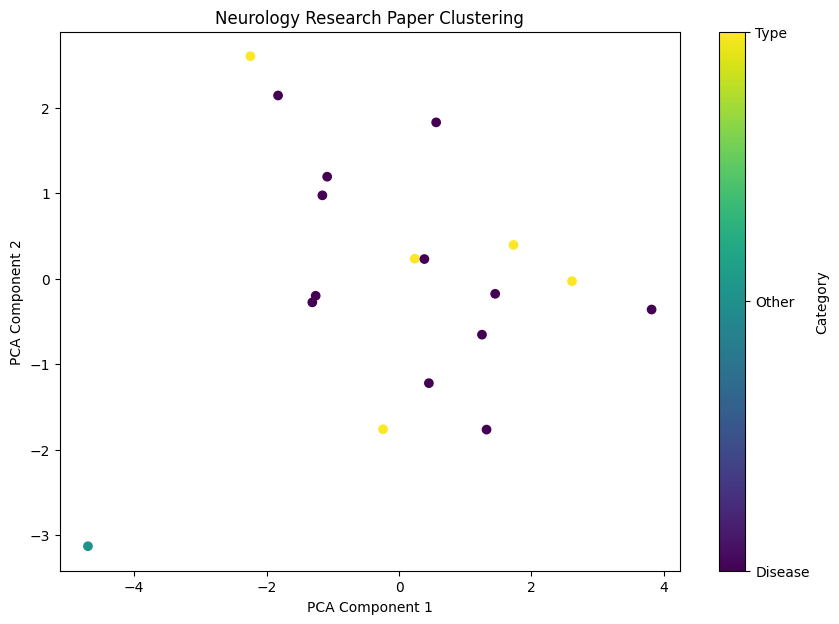

                                            Document  \
0  /content/drive/MyDrive/Topic Modelling on Neur...   
1  /content/drive/MyDrive/Topic Modelling on Neur...   
2  /content/drive/MyDrive/Topic Modelling on Neur...   
3  /content/drive/MyDrive/Topic Modelling on Neur...   
4  /content/drive/MyDrive/Topic Modelling on Neur...   

                                                Text Category  
0  ageing research review 99 2024 102390 availabl...  Disease  
1  ageing research review 99 2024 102355 availabl...  Disease  
2  ageing research review 99 2024 102325 availabl...     Type  
3  ageing research review 99 2024 102392 availabl...  Disease  
4  ageing research review 99 2024 102357 availabl...  Disease  


In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Keywords for semi-supervised classification
keyword_dict = {
    'Disease': ['Alzheimer', 'Parkinson', 'dementia'],
    'Type': ['genetic', 'neurological', 'cognitive'],
    'Treatment': ['therapy', 'medication', 'intervention'],
    'Other': ['risk', 'factors', 'lifestyle']
}

# Preprocessing Function
def preprocess_text(text):
  """Preprocesses text by removing punctuation,
  lowercasing, tokenizing, removing stop words, and lemmatizing."""
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = text.lower()  # Convert to lowercase
  tokens = word_tokenize(text)  # Tokenize the text
  stop_words = set(stopwords.words('english'))  # Get English stop words
  tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
  lemmatizer = WordNetLemmatizer()  # Initialize WordNetLemmatizer
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
  return ' '.join(lemmatized_tokens)  # Join tokens back into a string

def classify_text(text):
    """Classifies text into Disease, Type, Treatment, or Other based on keywords."""
    for category, keywords in keyword_dict.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'  # Default to 'Other' if no keywords match

# Visualization for Clusters
def visualize_clusters(embeddings, labels):
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))

    # Convert labels to numerical values for color mapping
    unique_labels = np.unique(labels)
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    numerical_labels = [label_mapping[label] for label in labels]

    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1],
                c=numerical_labels, cmap='viridis', marker='o') # Use numerical_labels for color
    plt.title("Neurology Research Paper Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

    # Add a colorbar with category labels
    cbar = plt.colorbar()
    cbar.set_ticks(np.arange(len(unique_labels)))
    cbar.set_ticklabels(unique_labels)
    cbar.set_label('Category')

    plt.show()

# Full Analysis
def analyze_research_papers(pdf_files, num_clusters=4):
    documents = []
    for pdf_file in pdf_files:
        text = extract_text_from_pdf(pdf_file)
        preprocessed_text = preprocess_text(text)
        documents.append(preprocessed_text)

    # Generate embeddings using SciBERT
    embeddings = get_embeddings(documents)

    # Label documents based on keywords
    labels = [classify_text(text) for text in documents]

    # Visualization
    visualize_clusters(embeddings, labels)

    # DataFrame to store results
    df = pd.DataFrame({
        'Document': pdf_files,
        'Text': documents,
        'Category': labels
    })
    print(df.head())
    return df

# Run analysis
df = analyze_research_papers(pdf_files=pdf_files, num_clusters=4)


The code performs clustering and visualization of scientific research papers based on their textual content.  Let's break down the key steps and the likely appearance of the graph:

1. **Data Loading and Preprocessing:**
   - It loads PDF files from a specified directory.
   - It preprocesses the text from each PDF:
     - Cleaning (removing punctuation, HTML tags, URLs, extra whitespace)
     - Tokenization (splitting text into words)
     - Stop word removal (eliminating common words like "the," "a," "is")
     - Lowercasing
     - Stemming/Lemmatization (reducing words to their root form)

2. **SciBERT Embeddings:**
   - Uses SciBERT (a scientific domain-specific language model) to generate embeddings (numerical representations) of the preprocessed text.  These embeddings capture semantic meaning.

3. **Clustering (K-Means):**
   - Applies K-Means clustering to group the papers based on their SciBERT embeddings.  The code uses `num_clusters=4`, meaning it groups the papers into four clusters.

4. **Semi-supervised Classification (Keyword-based):**
   - It assigns each paper to a category (Disease, Type, Treatment, or Other) based on the presence of specific keywords.  This is a rudimentary classification step.  It's not used for the clustering itself but rather for labeling the data points in the visualization.

5. **Visualization (PCA and Scatter Plot):**
   - Reduces the dimensionality of the SciBERT embeddings using Principal Component Analysis (PCA) to 2 dimensions.  This allows for visualization in a 2D scatter plot.
   - Creates a scatter plot where each point represents a research paper.
   - The points are colored based on the assigned category (from the keyword-based classification). Each color represents a category (Disease, Type, Treatment, or Other).
   - The plot will likely show clusters of points, with each cluster representing a group of papers with similar content. The cluster separation might not be perfect, due to the limitations of keyword-based classification and the nature of K-Means clustering. The colors will indicate the category of papers within each cluster.


**In summary:** You'll see a 2D scatter plot where points are colored according to the four categories determined by keywords.  Clusters of points suggest groupings of papers with similar content, as determined by the SciBERT embeddings and K-means clustering.  The visualization helps to explore the relationships between the research papers. The quality of the clustering and visualization would depend on the quality of the text preprocessing and keyword dictionary

In [17]:
# Save the DataFrame to a CSV file in Google Drive
csv_file_path = '/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/cleaned_data.csv'
df.to_csv(csv_file_path, index=False)

In [18]:
from collections import defaultdict

# Define the expanded keyword dictionary with primary and secondary keywords
keywords = {
    "Disease": ["Alzheimer’s", "Parkinson’s", "Dementia", "cognitive decline", "motor disorder"],
    "Type": ["neurodegenerative", "inflammatory", "genetic", "age-related"],
    "Treatment": ["medication", "therapy", "surgery", "pharmaceutical", "neurostimulation"],
    "Other": ["imaging", "biomarkers", "epidemiology", "genetic markers"]
}

# Function to classify text based on keywords
def classify_text(text):
    category_scores = defaultdict(int)

    for category, terms in keywords.items():
        for term in terms:
            if term.lower() in text.lower():
                # Increase score, adjust weight for primary vs secondary keywords if needed
                category_scores[category] += 1

    # Determine the category with the highest score
    if category_scores:
        return max(category_scores, key=category_scores.get)
    return "Uncategorized"

# Example usage on a research paper abstract
text_sample = "The study focuses on neurodegenerative diseases such as Alzheimer’s and the effect of cognitive therapy."
category = classify_text(text_sample)
print(f"Classified as: {category}")



Classified as: Disease


In [19]:
from collections import defaultdict
import pandas as pd

# Expanded keywords with primary and secondary terms
keywords = {
    "Disease": {"primary": ["Alzheimer’s", "Parkinson’s", "Dementia"],
                "secondary": ["cognitive decline", "neurodegeneration"]},
    "Type": {"primary": ["neurodegenerative", "genetic"],
             "secondary": ["age-related", "inflammatory"]},
    "Treatment": {"primary": ["therapy", "medication", "surgery"],
                  "secondary": ["neurostimulation", "pharmaceutical"]},
    "Other": {"primary": ["imaging", "biomarkers"],
              "secondary": ["genetic markers", "epidemiology"]}
}

# Classification function with multi-label and scoring
def classify_text_multi_label(text, threshold=2):
    category_scores = defaultdict(int)

    # Calculate scores for each category
    for category, terms in keywords.items():
        for term in terms["primary"]:
            if term.lower() in text.lower():
                category_scores[category] += 2  # Higher weight for primary terms
        for term in terms["secondary"]:
            if term.lower() in text.lower():
                category_scores[category] += 1  # Lower weight for secondary terms

    # Determine categories that meet the score threshold
    assigned_categories = [category for category, score in category_scores.items() if score >= threshold]

    return assigned_categories if assigned_categories else ["Uncategorized"]

# Function to classify all documents and create a DataFrame
def classify_documents(documents):
    classified_data = []

    for i, text in enumerate(documents):
        categories = classify_text_multi_label(text)
        classified_data.append({"Document_ID": i, "Text": text, "Categories": categories})

    return pd.DataFrame(classified_data)

# Assuming `df` contains the text data, replace it with the actual DataFrame
documents = df['Text'].tolist()  # Extract text data from the DataFrame 'df'

# Classify documents and store results in a DataFrame
df_classified = classify_documents(documents)

# Display the DataFrame with classifications
print(df_classified)



    Document_ID                                               Text  \
0             0  ageing research review 99 2024 102390 availabl...   
1             1  ageing research review 99 2024 102355 availabl...   
2             2  ageing research review 99 2024 102325 availabl...   
3             3  ageing research review 99 2024 102392 availabl...   
4             4  ageing research review 99 2024 102357 availabl...   
5             5  ageing research review editorinchief c frances...   
6             6  ageing research review 99 2024 102383 availabl...   
7             7  ageing research review 99 2024 102385 availabl...   
8             8  ageing research review 99 2024 102407 availabl...   
9             9  ageing research review 99 2024 102380 availabl...   
10           10  ageing research review 99 2024 102360 availabl...   
11           11  ageing research review 99 2024 102402 availabl...   
12           12  ageing research review 99 2024 102354 availabl...   
13           13  age

In [20]:
df.head()

,Document,Text,Category
0,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102390 availabl...,Disease
1,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102355 availabl...,Disease
2,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102325 availabl...,Type
3,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102392 availabl...,Disease
4,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102357 availabl...,Disease


In [21]:
df.shape

(18, 3)

In [22]:
df.count()

,0
Document,18
Text,18
Category,18


#Understanding data

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Document  18 non-null     object
 1   Text      18 non-null     object
 2   Category  18 non-null     object
dtypes: object(3)
memory usage: 560.0+ bytes


#Duplicate Values

In [24]:
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, list)).any():  # Check if column has lists
        df[col] = df[col].map(lambda x: tuple(x) if isinstance(x, list) else x)

# Now check for duplicates
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


#Missing Values

In [25]:
# Missing Values/Null Values Count
df.isna().sum()

,0
Document,0
Text,0
Category,0


In [35]:
# Display unique categories in the 'Category' column
print(df['Category'].unique())

['Disease' 'Type' 'Other']


In [42]:
# prompt: according to category generate prompts to help researchers

def generate_research_prompts(category, keywords):
  """Generates research prompts based on a category and keywords.

  Args:
    category: The research category (e.g., "Disease", "Treatment").
    keywords: A list of keywords relevant to the category.

  Returns:
    A list of research prompts.
  """

  prompts = []

  # Generate prompts based on different prompt templates
  if category == "Disease":
    prompts.extend([
        f"Investigate the genetic basis of {keywords[0]}.",
        f"Explore the relationship between lifestyle factors and the risk of {keywords[1]}.",
        f"Analyze the effectiveness of different therapies for {keywords[2]}."
    ])

  elif category == "Type":
    prompts.extend([
      f"Compare and contrast {keywords[0]} and {keywords[1]} diseases.",
      f"Study the prevalence of {keywords[2]} neurological disorders in different populations.",
      f"Investigate the role of genetic factors in {keywords[0]} diseases."
    ])

  elif category == "Treatment":
      prompts.extend([
          f"Evaluate the efficacy of {keywords[0]} for {keywords[1]}.",
          f"Explore novel treatment strategies for {keywords[2]}.",
          f"Assess the long-term effects of {keywords[0]} on patients with {keywords[1]}."
      ])

  elif category == "Other":
      prompts.extend([
          f"Develop new biomarkers for early detection of {keywords[0]}",
          f"Investigate the role of {keywords[1]} in disease progression",
          f"Explore the use of {keywords[2]} for improved patient outcomes"
      ])
  else:
      prompts.append(f"Explore research related to {keywords}")

  return prompts

# Example usage
disease_keywords = ["Alzheimer's Disease", "Parkinson's Disease", "Dementia"]
disease_prompts = generate_research_prompts("Disease", disease_keywords)
print("Disease Prompts:")
for prompt in disease_prompts:
  print(prompt)

treatment_keywords = ["medication", "therapy", "surgery"]
treatment_prompts = generate_research_prompts("Treatment", treatment_keywords)
for prompt in treatment_prompts:
  print(prompt)

Disease Prompts:
Investigate the genetic basis of Alzheimer's Disease.
Explore the relationship between lifestyle factors and the risk of Parkinson's Disease.
Analyze the effectiveness of different therapies for Dementia.
Evaluate the efficacy of medication for therapy.
Explore novel treatment strategies for surgery.
Assess the long-term effects of medication on patients with therapy.


#Neurological Document Insights: Chain-of-Thought Q&A with Multi-Label Categorization

In [47]:
from collections import defaultdict
import pandas as pd

def answer_question_from_pdfs(question, pdf_files, df_classified, keywords):
    """
    Answers a question using a chain-of-thought process and information retrieved from PDFs.

    Parameters:
        question (str): The question to answer.
        pdf_files (list): List of PDF file paths.
        df_classified (pd.DataFrame): DataFrame with classified documents and categories.
        keywords (dict): Dictionary of keywords categorized by primary and secondary terms.
    """

    # 1. Analyze the question and identify relevant categories and keywords
    question_keywords = question.lower().split()
    relevant_categories = []

    for category, terms in keywords.items():
        for term_type, term_list in terms.items():
            if any(term.lower() in question_keywords for term in term_list):
                relevant_categories.append(category)
                break  # Stop searching once a relevant category is found

    # 2. Filter relevant documents based on the identified categories
    relevant_pdfs = []
    if relevant_categories:
        for index, row in df_classified.iterrows():
            if any(category in row['Categories'] for category in relevant_categories):
                relevant_pdfs.append((row['Document_ID'], row['Text']))
    else:
        # Handle cases where no category matches are found
        return "No relevant information found for this question."

    # 3. Chain-of-thought reasoning and answer generation
    answer = ""
    if relevant_pdfs:
        for doc_id, text in relevant_pdfs:
            # Check if any question keyword exists in the text of the document
            if any(keyword in text.lower() for keyword in question_keywords):
                answer += f"Based on document {doc_id}:\n"
                answer += f"{text[:200]}...\n"  # Excerpt from the text (adjust length as needed)

                # Indicate relevant category information
                categories = df_classified.loc[df_classified['Document_ID'] == doc_id, 'Categories'].iloc[0]
                for category in categories:
                    answer += f"This document is related to the category: {category}\n"

        if not answer:
            answer = "No direct answer found, but the question is related to the following categories: " + ", ".join(relevant_categories)
    else:
        answer = "No relevant documents found based on the question."

    return answer

# Example usage:
question = "What are the genetic factors related to Alzheimer's?"
# df_classified is assumed to be preloaded with columns ['Document_ID', 'Text', 'Categories']
keywords = {
    "Disease": {"primary": ["Alzheimer’s", "Parkinson’s", "Dementia"],
                "secondary": ["cognitive decline", "neurodegeneration"]},
    "Type": {"primary": ["neurodegenerative", "genetic"],
             "secondary": ["age-related", "inflammatory"]},
    "Treatment": {"primary": ["therapy", "medication", "surgery"],
                  "secondary": ["neurostimulation", "pharmaceutical"]},
    "Other": {"primary": ["imaging", "biomarkers"],
              "secondary": ["genetic markers", "epidemiology"]}
}

# Assuming df_classified DataFrame is already populated
answer = answer_question_from_pdfs(question, pdf_files=[], df_classified=df_classified, keywords=keywords)
print(answer)


Based on document 0:
ageing research review 99 2024 102390 available online 24 june 2024 15681637 2024 author published elsevier bv open access article cc license httpcreativecommonsorglicensesby40 review article exposure...
This document is related to the category: Disease
This document is related to the category: Type
This document is related to the category: Treatment
This document is related to the category: Other
Based on document 2:
ageing research review 99 2024 102325 available online 1 june 2024 15681637 2024 author published elsevier bv open access article cc license httpcreativecommonsorglicensesby40 review article effect do...
This document is related to the category: Type
This document is related to the category: Treatment
This document is related to the category: Other
Based on document 3:
ageing research review 99 2024 102392 available online 24 june 2024 15681637 2024 author published elsevier bv open access article cc license httpcreativecommonsorglicensesby40 review a

                                                 Document  \
count                                                  18   
unique                                                 18   
top     /content/drive/MyDrive/Topic Modelling on Neur...   
freq                                                    1   

                                                     Text Category  
count                                                  18       18  
unique                                                 18        3  
top     ageing research review 99 2024 102390 availabl...  Disease  
freq                                                    1       12  

Duplicate rows:
Empty DataFrame
Columns: [Document, Text, Category]
Index: []

Missing values per column:
Document    0
Text        0
Category    0
dtype: int64

Value counts for 'Category':
Category
Disease    12
Type        5
Other       1
Name: count, dtype: int64

Value counts for 'Categories' in df_classified:
Categories
[Disease: Alzheimer'

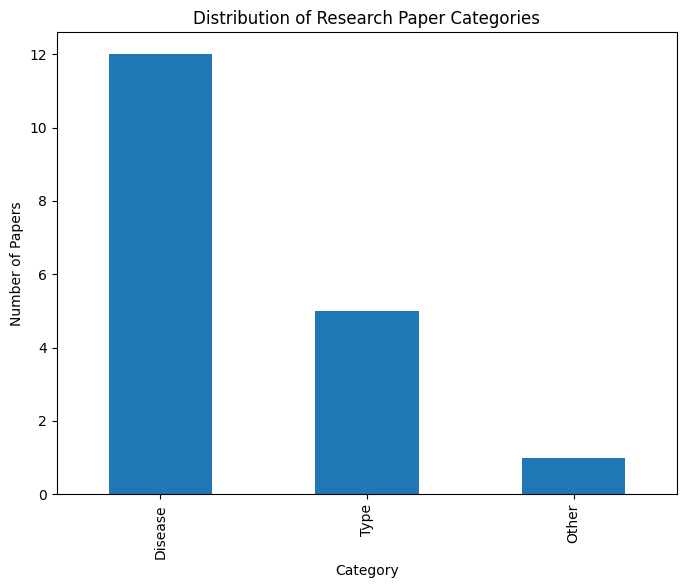

In [115]:
# Display basic statistics
print(df.describe())

# Check for duplicates after converting lists to tuples
print("\nDuplicate rows:")
print(df[df.duplicated()])

# Analyze missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Analyze the 'Category' column
print("\nValue counts for 'Category':")
print(df['Category'].value_counts())

# Further analysis of the 'Categories' column in df_classified
print("\nValue counts for 'Categories' in df_classified:")
print(df_classified['Categories'].value_counts())

# Example of analyzing the distribution of categories
category_counts = df['Category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Research Paper Categories')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.show()

##keywords with primary and secondary terms

In [48]:
from collections import defaultdict
import pandas as pd

# Define keywords with primary and secondary terms
keywords = {
    "Disease": {"primary": ["Alzheimer’s", "Parkinson’s", "Dementia"],
                "secondary": ["cognitive decline", "neurodegeneration"]},
    "Type": {"primary": ["neurodegenerative", "genetic"],
             "secondary": ["age-related", "inflammatory"]},
    "Treatment": {"primary": ["therapy", "medication", "surgery"],
                  "secondary": ["neurostimulation", "pharmaceutical"]},
    "Other": {"primary": ["imaging", "biomarkers"],
              "secondary": ["genetic markers", "epidemiology"]}
}

def classify_text_multi_label(text, threshold=2):
    category_scores = defaultdict(int)
    for category, terms in keywords.items():
        for term in terms["primary"]:
            if term.lower() in text.lower():
                category_scores[category] += 2
        for term in terms["secondary"]:
            if term.lower() in text.lower():
                category_scores[category] += 1
    assigned_categories = [category for category, score in category_scores.items() if score >= threshold]
    return assigned_categories if assigned_categories else ["Uncategorized"]

# Function to classify all documents
def classify_documents(documents):
    classified_data = []
    for i, text in enumerate(documents):
        categories = classify_text_multi_label(text)
        classified_data.append({"Document_ID": i, "Text": text, "Categories": categories})
    return pd.DataFrame(classified_data)


In [49]:
from sentence_transformers import SentenceTransformer, util

# Load the model for semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

def retrieve_and_answer(question, df_classified, keywords, similarity_threshold=0.6):
    question_keywords = question.lower().split()
    relevant_categories = []

    # Determine relevant categories based on keywords in the question
    for category, terms in keywords.items():
        for keyword_type in terms:
            for keyword in terms[keyword_type]:
                if keyword.lower() in question_keywords:
                    relevant_categories.append(category)
                    break

    # Filter relevant documents based on categories
    relevant_pdfs = []
    if relevant_categories:
        for _, row in df_classified.iterrows():
            if any(category in row['Categories'] for category in relevant_categories):
                relevant_pdfs.append((row['Document_ID'], row['Text']))

    # Chain-of-Thought and Semantic Similarity Filtering
    answer = ""
    if relevant_pdfs:
        question_embedding = model.encode(question, convert_to_tensor=True)
        for doc_id, text in relevant_pdfs:
            text_embedding = model.encode(text, convert_to_tensor=True)
            similarity_score = util.pytorch_cos_sim(question_embedding, text_embedding).item()

            if similarity_score > similarity_threshold:
                answer += f"Document {doc_id}:\n{text[:300]}...\n"
    return answer if answer else "No highly relevant excerpts found."


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##Meta-based prompting

In [125]:
def generate_meta_prompt(question, relevant_docs):  # Removed 'metadata'
    prompt = (
        "The following documents are relevant to the question. Please answer the question "
        "by considering not just individual excerpts but how the documents interconnect and "
        "relate to each other. Use meta-level reasoning to extract meaningful information.\n\n"
    )

    for doc_id, text in relevant_docs:
        prompt += f"Document {doc_id}: {text[:500]}...\n"

    prompt += f"\nQuestion: {question}\nAnswer: "
    return prompt


In [126]:
# Generate meta-based prompt with additional document metadata
meta_prompt = generate_meta_prompt(question, relevant_docs)
print(meta_prompt)


The following documents are relevant to the question. Please answer the question by considering not just individual excerpts but how the documents interconnect and relate to each other. Use meta-level reasoning to extract meaningful information.

Document 1: This research paper discusses Alzheimer's disease and its genetic markers......

Question: What are the genetic factors related to Alzheimer's?
Answer: 


##Context based prompting

In [99]:
def generate_prompt(question, relevant_docs):
    prompt = f"Given the following documents, please provide relevant information to answer the question:\n"
    for doc_id, text in relevant_docs:
        prompt += f"\nDocument {doc_id}: {text[:500]}...\n"
    prompt += f"\nQuestion: {question}\nAnswer: "
    return prompt


In [128]:
# Generate a context-based prompt to provide background information
context_prompt = generate_prompt(question, relevant_docs)
print(context_prompt)


Given the following documents, please provide relevant information to answer the question:

Document 1: This research paper discusses Alzheimer's disease and its genetic markers......

Question: What are the genetic factors related to Alzheimer's?
Answer: 


##Node-Based Prompting

In [102]:
def generate_node_prompt(question, relevant_docs, graph_structure=None):
    prompt = (
        "You have the following documents, and the question to answer. Please use the underlying "
        "graph structure of the documents, where each document or concept is a node, to find the "
        "most relevant information. Consider both direct and indirect connections between nodes "
        "when answering the question.\n\n"
    )

    for doc_id, text in relevant_docs:
        prompt += f"Document {doc_id}: {text[:500]}...\n"

    if graph_structure:
        prompt += f"\nGraph Structure: {graph_structure}\n"

    prompt += f"\nQuestion: {question}\nAnswer: "
    return prompt


In [129]:
# Generate a node-based prompt where key concepts are treated as nodes
node_prompt = generate_node_prompt(question, relevant_docs)
print(node_prompt)


You have the following documents, and the question to answer. Please use the underlying graph structure of the documents, where each document or concept is a node, to find the most relevant information. Consider both direct and indirect connections between nodes when answering the question.

Document 1: This research paper discusses Alzheimer's disease and its genetic markers......

Question: What are the genetic factors related to Alzheimer's?
Answer: 


##Interconnected Prompting

In [104]:
def generate_interconnected_prompt(question, relevant_docs):
    """

    Args:
      question:
      relevant_docs:

    Returns:

    """
    prompt = (
        "Answer the following question by examining how the documents interconnect. Each document may "
        "contain related information about diseases, treatments, or other relevant factors. Please explore "
        "the interconnections between these entities when answering.\n\n"
    )

    for doc_id, text in relevant_docs:
        prompt += f"Document {doc_id}: {text[:500]}...\n"

    prompt += f"\nQuestion: {question}\nAnswer: "
    return prompt


In [130]:
# Generate an interconnected prompt that links relevant information
interconnected_prompt = generate_interconnected_prompt(question, relevant_docs)
print(interconnected_prompt)


Answer the following question by examining how the documents interconnect. Each document may contain related information about diseases, treatments, or other relevant factors. Please explore the interconnections between these entities when answering.

Document 1: This research paper discusses Alzheimer's disease and its genetic markers......

Question: What are the genetic factors related to Alzheimer's?
Answer: 


##Hidden Conceptual Prompting

In [105]:
def generate_hidden_prompt(question, relevant_docs):
    prompt = (
        "Please answer the following question by thinking beyond the surface level of the documents. "
        "Look for hidden connections, such as implied relationships between treatments, diseases, or types of conditions. "
        "You may need to draw from your general knowledge to infer relevant details.\n\n"
    )

    for doc_id, text in relevant_docs:
        prompt += f"Document {doc_id}: {text[:500]}...\n"

    prompt += f"\nQuestion: {question}\nAnswer: "
    return prompt


In [131]:
# Generate a hidden prompt to extract less obvious but useful information
hidden_prompt = generate_hidden_prompt(question, relevant_docs)
print(hidden_prompt)


Please answer the following question by thinking beyond the surface level of the documents. Look for hidden connections, such as implied relationships between treatments, diseases, or types of conditions. You may need to draw from your general knowledge to infer relevant details.

Document 1: This research paper discusses Alzheimer's disease and its genetic markers......

Question: What are the genetic factors related to Alzheimer's?
Answer: 


##Combining Prompts for Enhanced Model Performance

In [106]:
def generate_combined_prompt(question, relevant_docs, graph_structure=None):
    prompt = (
        "You are tasked with answering a question by analyzing a collection of documents. The documents "
        "contain interconnected information, and some hidden relationships may be inferred. Use meta-level reasoning, "
        "explore the underlying graph structure, and consider the interconnectedness between different nodes to "
        "formulate a comprehensive answer.\n\n"
    )

    for doc_id, text in relevant_docs:
        prompt += f"Document {doc_id}: {text[:500]}...\n"

    if graph_structure:
        prompt += f"\nGraph Structure: {graph_structure}\n"

    prompt += f"\nQuestion: {question}\nAnswer: "
    return prompt


In [132]:
question = "What are the genetic factors related to Alzheimer's?"
relevant_docs = []  # Populate with relevant documents based on the question

# Populate relevant_docs with documents mentioning Alzheimer's
for index, row in df_classified.iterrows():
    if "Alzheimer's" in row["Text"]:
        relevant_docs.append((row["Document_ID"], row["Text"]))

# Generate the combined prompt
combined_prompt = generate_combined_prompt(question, relevant_docs)
print(combined_prompt)


You are tasked with answering a question by analyzing a collection of documents. The documents contain interconnected information, and some hidden relationships may be inferred. Use meta-level reasoning, explore the underlying graph structure, and consider the interconnectedness between different nodes to formulate a comprehensive answer.

Document 1: This research paper discusses Alzheimer's disease and its genetic markers......

Question: What are the genetic factors related to Alzheimer's?
Answer: 


In [133]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load the model for semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example document classification (this should be populated with actual data)
data = {
    "Document_ID": [1, 2, 3],
    "Text": [
        "Genetic factors in Alzheimer's include mutations in APOE and other genes.",
        "Parkinson's disease is characterized by motor symptoms and progressive neurodegeneration.",
        "Treatment options for Alzheimer's disease include medication like donepezil."
    ],
    "Categories": [['Alzheimer\'s', 'Genetics'], ['Parkinson\'s', 'Neurodegeneration'], ['Alzheimer\'s', 'Treatment']]
}

df_classified = pd.DataFrame(data)

# Define some example keywords for meta-based prompting
keywords = {
    "Alzheimer's": {"Genetics": ["APOE", "genetic mutations"], "Treatment": ["donepezil", "medication"]},
    "Parkinson's": {"Neurodegeneration": ["dopamine", "motor symptoms"]},
}

def generate_combined_prompt(question, relevant_docs):
    prompt = f"Given the question '{question}', here are some relevant documents:\n"
    for doc_id, text in relevant_docs:
        prompt += f"\nDocument {doc_id}:\n{text}\n"
    prompt += "\nNow, based on the above documents, answer the question."
    return prompt

def generate_meta_prompt(question, relevant_docs):
    prompt = f"Meta-based retrieval of information for the question '{question}':\n"
    prompt += "The documents are organized by categories such as Alzheimer's, Parkinson's, etc.\n"
    for doc_id, text in relevant_docs:
        prompt += f"\nDocument {doc_id}: {text[:150]}...\n"
    prompt += "\nPlease answer the question using these documents."
    return prompt

def generate_prompt(question, relevant_docs):
    prompt = f"Given the question: {question}, here are the relevant documents:\n"
    for doc_id, text in relevant_docs:
        prompt += f"\nDocument {doc_id}:\n{text}\n"
    prompt += "\nPlease summarize the answer based on the above content."
    return prompt

def generate_node_prompt(question, relevant_docs):
    prompt = f"Question: {question}\nThe documents have been categorized into nodes such as Genetics, Treatment, and Symptoms.\n"
    for doc_id, text in relevant_docs:
        prompt += f"\nDocument {doc_id}: {text[:150]}...\n"
    prompt += "\nProvide the relevant answer based on these nodes."
    return prompt

def generate_interconnected_prompt(question, relevant_docs):
    prompt = f"Interconnected response for the question: {question}\nThis will integrate information from different document categories like Genetics, Treatment, and Symptoms.\n"
    for doc_id, text in relevant_docs:
        prompt += f"\nDocument {doc_id}: {text[:150]}...\n"
    prompt += "\nPlease generate an integrated answer using these connections."
    return prompt

def generate_hidden_prompt(question, relevant_docs):
    prompt = f"Hidden aspects of the question: {question}\nHere are the documents with underlying data:\n"
    for doc_id, text in relevant_docs:
        prompt += f"\nDocument {doc_id}: {text[:150]}...\n"
    prompt += "\nBased on the hidden details, answer the question."
    return prompt

# Function to retrieve relevant documents for a given question
def retrieve_and_answer(question, df_classified, keywords, similarity_threshold=0.6):
    question_keywords = question.lower().split()
    relevant_categories = []

    # Determine relevant categories based on keywords in the question
    for category, terms in keywords.items():
        for keyword_type in terms:
            for keyword in terms[keyword_type]:
                if keyword.lower() in question_keywords:
                    relevant_categories.append(category)
                    break

    # Filter relevant documents based on categories
    relevant_docs = []
    if relevant_categories:
        for _, row in df_classified.iterrows():
            if any(category in row['Categories'] for category in relevant_categories):
                relevant_docs.append((row['Document_ID'], row['Text']))

    # Chain-of-Thought and Semantic Similarity Filtering
    answer = ""
    if relevant_docs:
        question_embedding = model.encode(question, convert_to_tensor=True)
        for doc_id, text in relevant_docs:
            text_embedding = model.encode(text, convert_to_tensor=True)
            similarity_score = util.pytorch_cos_sim(question_embedding, text_embedding).item()

            if similarity_score > similarity_threshold:
                answer += f"Document {doc_id}:\n{text[:300]}...\n"

    return answer if answer else "No highly relevant excerpts found."

# Example question
question = "What are the genetic factors related to Alzheimer's?"

# Retrieve relevant documents and generate answers
relevant_docs = []
for index, row in df_classified.iterrows():
    if "Alzheimer's" in row["Text"]:
        relevant_docs.append((row["Document_ID"], row["Text"]))

# Generate various prompts
combined_prompt = generate_combined_prompt(question, relevant_docs)
meta_prompt = generate_meta_prompt(question, relevant_docs)
context_prompt = generate_prompt(question, relevant_docs)
node_prompt = generate_node_prompt(question, relevant_docs)
interconnected_prompt = generate_interconnected_prompt(question, relevant_docs)
hidden_prompt = generate_hidden_prompt(question, relevant_docs)

# Print the prompts for review
print("Combined Prompt:\n", combined_prompt)
print("Meta Prompt:\n", meta_prompt)
print("Context Prompt:\n", context_prompt)
print("Node Prompt:\n", node_prompt)
print("Interconnected Prompt:\n", interconnected_prompt)
print("Hidden Prompt:\n", hidden_prompt)


Combined Prompt:
 Given the question 'What are the genetic factors related to Alzheimer's?', here are some relevant documents:

Document 1:
Genetic factors in Alzheimer's include mutations in APOE and other genes.

Document 3:
Treatment options for Alzheimer's disease include medication like donepezil.

Now, based on the above documents, answer the question.
Meta Prompt:
 Meta-based retrieval of information for the question 'What are the genetic factors related to Alzheimer's?':
The documents are organized by categories such as Alzheimer's, Parkinson's, etc.

Document 1: Genetic factors in Alzheimer's include mutations in APOE and other genes....

Document 3: Treatment options for Alzheimer's disease include medication like donepezil....

Please answer the question using these documents.
Context Prompt:
 Given the question: What are the genetic factors related to Alzheimer's?, here are the relevant documents:

Document 1:
Genetic factors in Alzheimer's include mutations in APOE and oth

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [134]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the pre-trained T5 model and tokenizer
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-small")

# Function to generate answer using the T5 model
def generate_answer_with_t5(prompt):
    input_ids = tokenizer_t5.encode(prompt, return_tensors="pt", max_length=512, truncation=True)
    output = model_t5.generate(input_ids, max_length=200, num_beams=5, early_stopping=True)
    answer = tokenizer_t5.decode(output[0], skip_special_tokens=True)
    return answer

# Generate answers for each prompt
combined_answer = generate_answer_with_t5(combined_prompt)
meta_answer = generate_answer_with_t5(meta_prompt)
context_answer = generate_answer_with_t5(context_prompt)
node_answer = generate_answer_with_t5(node_prompt)
interconnected_answer = generate_answer_with_t5(interconnected_prompt)
hidden_answer = generate_answer_with_t5(hidden_prompt)

# Print the generated answers
print("Combined Answer:", combined_answer)
print("Meta Answer:", meta_answer)
print("Context Answer:", context_answer)
print("Node Answer:", node_answer)
print("Interconnected Answer:", interconnected_answer)
print("Hidden Answer:", hidden_answer)


Combined Answer: the question 'What are the genetic factors related to Alzheimer's?', here are some relevant documents: Document 1: Genetic factors in Alzheimer's include mutations in APOE and other genes. Document 3: Treatment options for Alzheimer's disease include medication like donepezil.
Meta Answer: Meta-based retrieval of information for the question 'What are the genetic factors related to Alzheimer's?': The documents are organized by categories such as Alzheimer's, Parkinson's, etc.
Context Answer: : What are the genetic factors related to Alzheimer's?, here are relevant documents: Document 1: Genetic factors in Alzheimer's include mutations in APOE and other genes. Document 3: Treatment options for Alzheimer's disease include medication like donepezil.
Node Answer: Document 1: Genetic factors in Alzheimer's include mutations in APOE and other genes.... Document 3: Treatment options for Alzheimer's disease include medication like donepezil.... Provide the relevant answer base

In [136]:
pip install datasets rouge-score nltk matplotlib


In [137]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np
import nltk

# Download necessary NLTK resources
nltk.download('punkt')

# Example reference answers (these would come from human annotations or your ground truth data)
reference_answers = {
    "combined": "Genetic factors such as mutations in APOE and other genes play a significant role in Alzheimer's.",
    "meta": "The genetic factors of Alzheimer's disease include variations in the APOE gene.",
    "context": "APOE genetic mutations are linked to Alzheimer's disease and significantly impact its development.",
    "node": "Alzheimer's disease is influenced by genetic mutations in APOE, contributing to early-onset forms.",
    "interconnected": "Genetic factors like APOE mutations are a major contributor to Alzheimer's disease pathology.",
    "hidden": "Alzheimer's is associated with genetic mutations, notably in the APOE gene, which affects brain function."
}

# Example generated answers (these would come from your model)
generated_answers = {
    "combined": combined_answer,
    "meta": meta_answer,
    "context": context_answer,
    "node": node_answer,
    "interconnected": interconnected_answer,
    "hidden": hidden_answer
}

# Function to calculate BLEU score
def calculate_bleu(reference, generated):
    reference_tokens = nltk.word_tokenize(reference.lower())
    generated_tokens = nltk.word_tokenize(generated.lower())
    return sentence_bleu([reference_tokens], generated_tokens)

# Function to calculate ROUGE score (ROUGE-L for longest common subsequence)
def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# Function to calculate Exact Match (EM) score
def calculate_em(reference, generated):
    return 1 if reference.strip().lower() == generated.strip().lower() else 0

# Store the results for BLEU, ROUGE, and EM
bleu_scores = {}
rouge_scores = {}
em_scores = {}

# Calculate metrics for each answer
for key in generated_answers:
    reference = reference_answers[key]
    generated = generated_answers[key]

    bleu_scores[key] = calculate_bleu(reference, generated)
    rouge_scores[key] = calculate_rouge(reference, generated)
    em_scores[key] = calculate_em(reference, generated)

# Print out the scores for inspection
for key in generated_answers:
    print(f"Metrics for {key} answer:")
    print(f"BLEU score: {bleu_scores[key]}")
    print(f"ROUGE score (ROUGE-1, ROUGE-2, ROUGE-L): {rouge_scores[key]}")
    print(f"Exact Match (EM): {em_scores[key]}\n")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Metrics for combined answer:
BLEU score: 0.12704697476198454
ROUGE score (ROUGE-1, ROUGE-2, ROUGE-L): {'rouge1': Score(precision=0.2619047619047619, recall=0.6470588235294118, fmeasure=0.37288135593220334), 'rouge2': Score(precision=0.1951219512195122, recall=0.5, fmeasure=0.28070175438596495), 'rougeL': Score(precision=0.23809523809523808, recall=0.5882352941176471, fmeasure=0.33898305084745767)}
Exact Match (EM): 0

Metrics for meta answer:
BLEU score: 1.9203203885662165e-78
ROUGE score (ROUGE-1, ROUGE-2, ROUGE-L): {'rouge1': Score(precision=0.23333333333333334, recall=0.5384615384615384, fmeasure=0.32558139534883723), 'rouge2': Score(precision=0.10344827586206896, recall=0.25, fmeasure=0.14634146341463414), 'rougeL': Score(precision=0.2, recall=0.46153846153846156, fmeasure=0.27906976744186046)}
Exact Match (EM): 0

Metrics for context answer:
BLEU score: 1.9246726263293519e-78
ROUGE score (ROUGE-1, ROUGE-2, ROUGE-L): {'rouge1': Score(precision=0.23076923076923078, recall=0.64285714

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


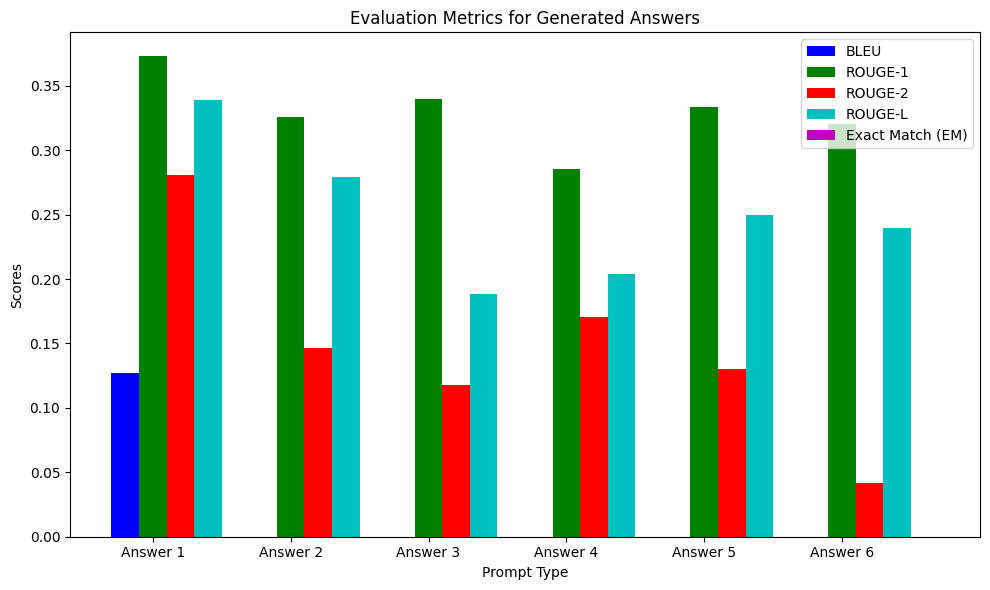

In [138]:
# Plot BLEU, ROUGE, and EM scores

# Prepare data for plotting
metric_names = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'EM']
metric_values = {
    'BLEU': [bleu_scores[key] for key in generated_answers],
    'ROUGE-1': [rouge_scores[key]['rouge1'].fmeasure for key in generated_answers],
    'ROUGE-2': [rouge_scores[key]['rouge2'].fmeasure for key in generated_answers],
    'ROUGE-L': [rouge_scores[key]['rougeL'].fmeasure for key in generated_answers],
    'EM': [em_scores[key] for key in generated_answers]
}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(generated_answers))

# Plot each metric
ax.bar(x_pos - 0.2, metric_values['BLEU'], width=0.2, label='BLEU', color='b')
ax.bar(x_pos, metric_values['ROUGE-1'], width=0.2, label='ROUGE-1', color='g')
ax.bar(x_pos + 0.2, metric_values['ROUGE-2'], width=0.2, label='ROUGE-2', color='r')
ax.bar(x_pos + 0.4, metric_values['ROUGE-L'], width=0.2, label='ROUGE-L', color='c')
ax.bar(x_pos + 0.6, metric_values['EM'], width=0.2, label='Exact Match (EM)', color='m')

# Add labels and title
ax.set_xlabel('Prompt Type')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Generated Answers')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"Answer {i+1}" for i in range(len(generated_answers))])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
